In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from Class_utils.parameters import file_paths,job_graph_par
from Class_utils.JobGraph import JobGraph
import ast

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

In [2]:
job_graph = JobGraph(file_paths, **job_graph_par)

Cache found loading...done


In [3]:
curricula = pd.read_csv("../outputs/test_50k_curricula.csv").set_index("kId")

In [4]:
curricula_md = pd.json_normalize(curricula["metadata"].apply(ast.literal_eval))
curricula_md.index.rename("kId", inplace=True)

In [5]:
counter = np.zeros((2, 5))
total = np.zeros((2, 5))
qId_error_comp,qId_error_know = [],[]


for kId, cv in tqdm(curricula.iterrows(),total=len(curricula)):
    
    competences = ast.literal_eval(cv["Competences"])
    un_comp, amb_comp = job_graph.skill_standardize(competences)
    de_amb_comp = job_graph.solve_ambiguous(amb_comp, un_comp)

    real_uris = curricula_md.loc[kId, "uri_competences"]
    total[0, len(amb_comp)] += 1
    equal_ = 0 if set(un_comp) | set(de_amb_comp)  ==  set(real_uris) else 1
    if equal_ == 1:
        counter[0, len(amb_comp)] += 1
        qId_error_comp.append(kId)

    knowledge = ast.literal_eval(cv["Knowledge"])
    un_know, amb_know = job_graph.skill_standardize(knowledge)
    de_amb_know = job_graph.solve_ambiguous(amb_know, un_know)

    real_uris = curricula_md.loc[kId, "uri_knowledge"]
    total[1, len(amb_know)] += 1
    equal_ = 0 if set(un_know) | set(de_amb_know)  ==  set(real_uris) else 1
    if equal_ == 1:
        counter[1, len(amb_know)] += 1
        qId_error_know.append(kId)


100%|██████████| 15890/15890 [00:06<00:00, 2313.59it/s]


In [6]:
counter

array([[  0., 176.,  37.,   4.,   0.],
       [  0., 610., 148.,  21.,   7.]])

In [7]:
total

array([[1.3406e+04, 2.2650e+03, 2.0600e+02, 1.2000e+01, 1.0000e+00],
       [1.2755e+04, 2.6940e+03, 4.0000e+02, 3.3000e+01, 8.0000e+00]])

In [8]:
total_, errors_ = list(total.sum(axis=0)), list(counter.sum(axis=0))
dt = pd.DataFrame(
    {
        "# ambiguous":[*range(len(errors_))],
        "perc": [e/t if t > 0 else 0 for t, e in zip(total_,errors_)],
        "%": [str(format(e/t, '.4f'))+" %" if t > 0 else "0.0000 %" for t, e in zip(total_,errors_)]
    })
dt.drop(0,inplace=True)
dt

,# ambiguous,perc,%
1,1,0.158500,0.1585 %
2,2,0.305281,0.3053 %
3,3,0.555556,0.5556 %
4,4,0.777778,0.7778 %


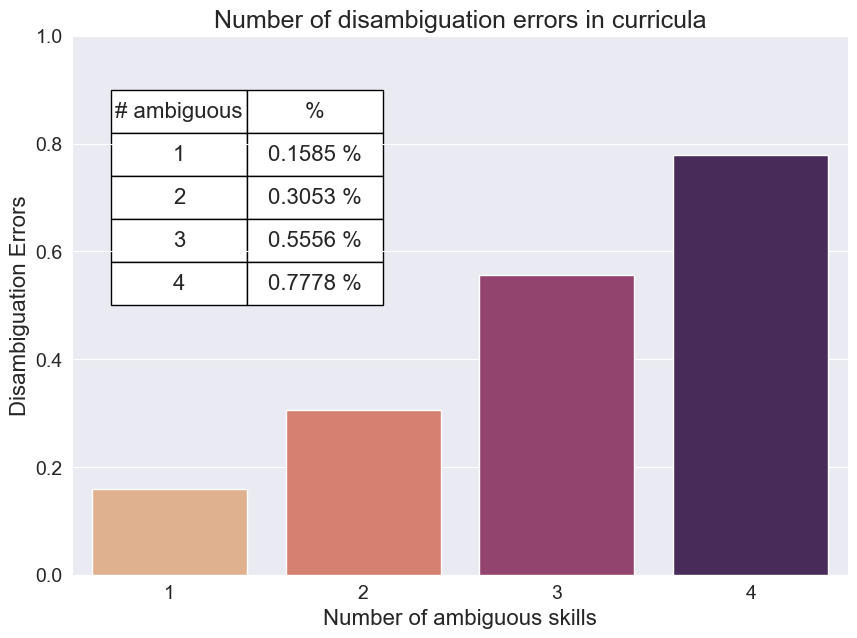

In [9]:
_, axs = plt.subplots(figsize=(10, 7))

sns.barplot(x="# ambiguous", y="perc", palette="flare", data=dt,hue="perc",legend=False, ax=axs)
sns.despine(left=True, bottom=True)
axs.set_title('Number of disambiguation errors in curricula', fontsize=18)
axs.set_xlabel('Number of ambiguous skills', fontsize=16)
axs.set_ylabel('Disambiguation Errors', fontsize=16)
axs.tick_params(axis='both', labelsize=14)
axs.set_ylim([0, 1])

table = plt.table(cellText=dt[["# ambiguous","%"]].values, colLabels=dt[["# ambiguous","%"]].columns,
                  cellLoc='center', bbox=[0.05, 0.5, 0.35, 0.4], loc='upper right')

table.auto_set_font_size(False)
table.set_fontsize(16)
plt.show()